In [4]:
# imports
import os, glob, random

import numpy as np  
import matplotlib.pyplot as plt
import matplotlib.style as style

import seaborn as sns

style.use('seaborn-whitegrid')
sns.set_palette("muted", 10)
sns.set()

In [5]:
#DataFlair - Emotions in the RAVDESS dataset
emotions={
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#DataFlair - Emotions to observe
observed_emotions=['happy','sad','angry','fearful','disgust','surprised']

In [11]:
#DataFlair - Extract features (mfcc, chroma, mel) from a sound file
import librosa
import soundfile
from sklearn.preprocessing import normalize

SAMPLERATE = 16000 # Hz

def extract_feature(file_name, norm=True):
    with soundfile.SoundFile(file_name) as sound_file:
        sample_rate=sound_file.samplerate
        X = sound_file.read(dtype="float32")
        if sample_rate != SAMPLERATE:
            X = librosa.resample(X, sample_rate, SAMPLERATE)
            sample_rate=SAMPLERATE 
        #print('filename=', file_name, ' samplerate=', sample_rate)        
        stft=np.abs(librosa.stft(X))
        if norm:
            mfccs = np.mean(normalize(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)).T, axis=0)
            chroma = np.mean(normalize(librosa.feature.chroma_stft(S=stft, sr=sample_rate)).T, axis=0)
            mel = np.mean(normalize(librosa.feature.melspectrogram(X, sr=sample_rate)).T, axis=0)
            tonnetz = np.mean(normalize(librosa.feature.tonnetz(y=X, sr=sample_rate)).T, axis=0)
            bandwidth = np.mean(normalize(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate)).T, axis=0)
            flatness = np.mean(normalize(librosa.feature.spectral_flatness(y=X)))
            contrast = np.mean(normalize(librosa.feature.spectral_contrast(y=X)))
        else:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T, axis=0)
            tonnetz = np.mean(librosa.feature.tonnetz(y=X, sr=sample_rate).T, axis=0)
            bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate).T, axis=0)
            flatness = np.mean(librosa.feature.spectral_flatness(y=X))
            contrast = np.mean(librosa.feature.spectral_contrast(y=X))
        result = np.hstack((mfccs, chroma, mel, tonnetz, bandwidth, flatness, contrast))
    return (X, result)

In [15]:
#DataFlair - Load the data and extract features for each sound file
from tqdm.autonotebook import tqdm
cwd = os.getcwd()

def load_data(glob_pattern=cwd+"/dataset/Actor_*/*.wav"):
    X,x,y=[],[],[]
    for file in tqdm(glob.glob(glob_pattern)):
        file_name=os.path.basename(file)
        if file_name.split("-")[2] == '01' or file_name.split("-")[2] == '02':
            continue
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        Xo, feature=extract_feature(file, norm=True)
        X.append(Xo)
        x.append(feature)
        y.append(emotion)
    return X,x,y

In [16]:
X,x,y = load_data()

100%|██████████| 1440/1440 [01:36<00:00, 14.86it/s]


In [17]:
pickle.dump((x,y), open("extracted-data-norm.pickle", "wb"))

In [18]:
import pickle
x,y = pickle.load(open("extracted-data.pickle", "rb" ))
xn,yn = pickle.load(open("extracted-data-norm.pickle", "rb" ))

In [11]:
import librosa.display

def plot_emo_specs(x,y,emos,n):
    index = 1
    nemos = len(emos)
    emo_data = dict()
    
    plt.figure()
    fig, axs = plt.subplots(nemos, n, figsize=(n*4,nemos*3), sharey=True,
                        gridspec_kw={'wspace': 0.01, 'hspace': 0.15})
    axs = axs.flatten()
    props = dict(boxstyle='round', facecolor='white', alpha=0.95)
    
    for emo in observed_emotions:
        xys = [xyi for xyi in zip(x, y) if xyi[1] == emo]
        emo_data[emo] = random.sample(xys, n)
        
        for i, samp in enumerate(emo_data[emo]):
            M = librosa.feature.melspectrogram(y=samp[0])
            ax = axs[index-1]
            librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', ax=ax)
            
            if (index-1) % n == 0:
                ax.text(0.05, 0.95, emo.capitalize(), 
                transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
            
            index += 1
    
    plt.tight_layout()        
    plt.show()

<Figure size 432x288 with 0 Axes>

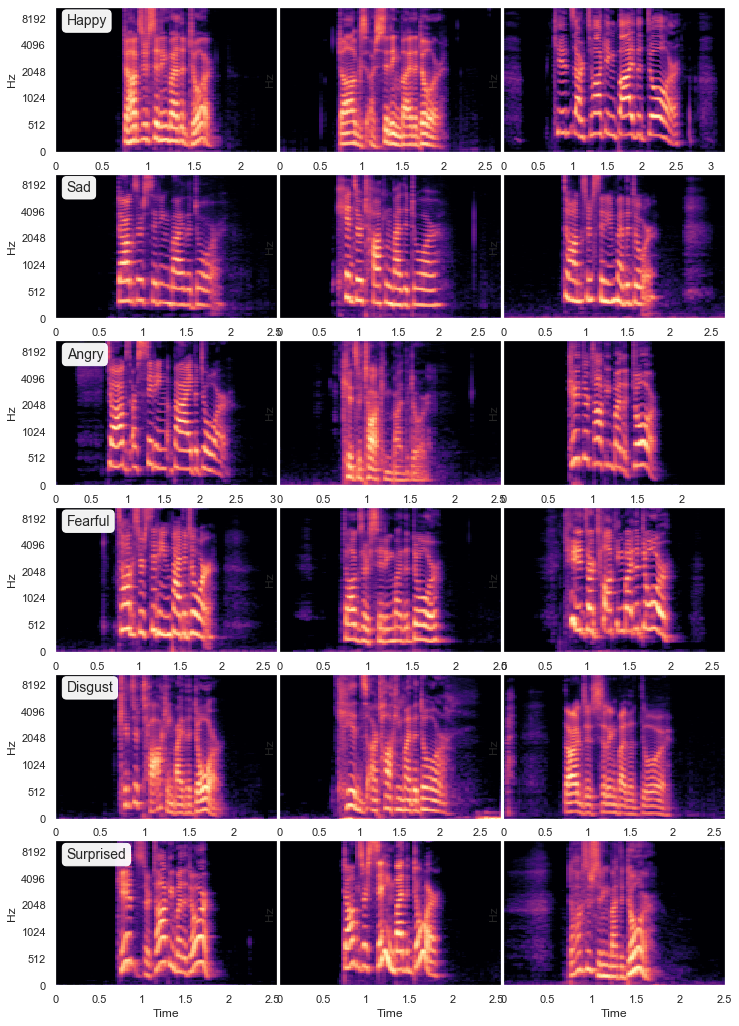

In [12]:
plot_emo_specs(X,y,observed_emotions, n=3)

In [19]:
from sklearn.model_selection import train_test_split

#REGULAR
random.seed(1)
np.random.seed(1)
x_train_strat,x_test_strat,y_train_strat,y_test_strat = train_test_split(np.array(x), y, test_size=0.2, 
                                                                        random_state=1, stratify=y)
random.seed(1)
np.random.seed(1)
x_train,x_test,y_train,y_test = train_test_split(np.array(x), y, test_size=0.2, random_state=1)

#NORM
random.seed(1)
np.random.seed(1)
xn_train_strat,xn_test_strat,yn_train_strat,yn_test_strat = train_test_split(np.array(xn), yn, test_size=0.2, 
                                                                        random_state=1, stratify=yn)
random.seed(1)
np.random.seed(1)
xn_train,xn_test,yn_train,yn_test = train_test_split(np.array(xn), yn, test_size=0.2, random_state=1)

In [20]:
# REGULAR
print((x_train_strat.shape[0], x_test_strat.shape[0]))
print((x_train.shape[0], x_test.shape[0]))
# NORM
print((xn_train_strat.shape[0], xn_test_strat.shape[0]))
print((xn_train.shape[0], xn_test.shape[0]))

(921, 231)
(921, 231)
(921, 231)
(921, 231)


In [22]:
#DataFlair - Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')
print(f'Features extracted: {xn_train.shape[1]}')

Features extracted: 189
Features extracted: 189


In [25]:
from sklearn import neighbors
from sklearn import svm
from sklearn import tree
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [75]:
# Classifiers - MLP, K-Nearest Neighbor, Support Vector Machine and Decision Tree Classifier
# change data here
XTR = xn_train
YTR = yn_train
XTE = xn_test
YTE = yn_test

mlp = MLPClassifier(alpha=0.01, batch_size=128, epsilon=1e-08, hidden_layer_sizes=(500,250,125,), learning_rate='adaptive', max_iter=2500)
# n=20 seems to be optimal
knn = neighbors.KNeighborsClassifier(20)
svm_clf = svm.SVC()
dtc = tree.DecisionTreeClassifier(max_depth=4)
nb = naive_bayes.GaussianNB()

# Newton-cg handles multinomial loss (for multiclass problems)
lr = linear_model.LogisticRegression(solver='newton-cg')

# Cross Validation using K-Fold
random.seed(1)
np.random.seed(1)
kf5 = KFold(n_splits=5, random_state=1)
random.seed(1)
np.random.seed(1)
skf5 = StratifiedKFold(n_splits=5, random_state=1)
random.seed(1)
np.random.seed(1)
kf10 = KFold(n_splits=10, random_state=1)
random.seed(1)
np.random.seed(1)
skf10 = StratifiedKFold(n_splits=10, random_state=1)

In [76]:
import pandas as pd

models = [("MLP", mlp), ("K-NearestNeighbors", knn), ("SupportVectorMachine", svm_clf),
          ("DecisionTreeClassifier", dtc), ("NaiveBayesGaussian", nb), ("LogisticRegression", lr)]
# validators = [("5-fold", kf5),  ("Stratified 5-fold", skf5)]
# or all validators?
validators = [("5-fold", kf5),  ("Stratified 5-fold", skf5), ("10-fold", kf10), ("Stratified 10-fold", skf10)]
val_res = {}

for name, validator in validators:
    val_res[name] = {}
    entries = []
    for model_name, model in tqdm(models, desc=name):
        random.seed(0)
        np.random.seed(0)
        # Scores of all folds per model
        scores = cross_val_score(model, XTR, YTR, cv=validator)
        val_res[name][model_name] = scores
        for fold_idx, score in enumerate(scores):
            entries.append((model_name, fold_idx, score))
    val_res[name] = pd.DataFrame(entries, columns=['clf_name', 'fold_idx', 'accuracy'])

Stratified 10-fold: 100%|██████████| 6/6 [02:49<00:00, 28.22s/it]


<Figure size 432x288 with 0 Axes>

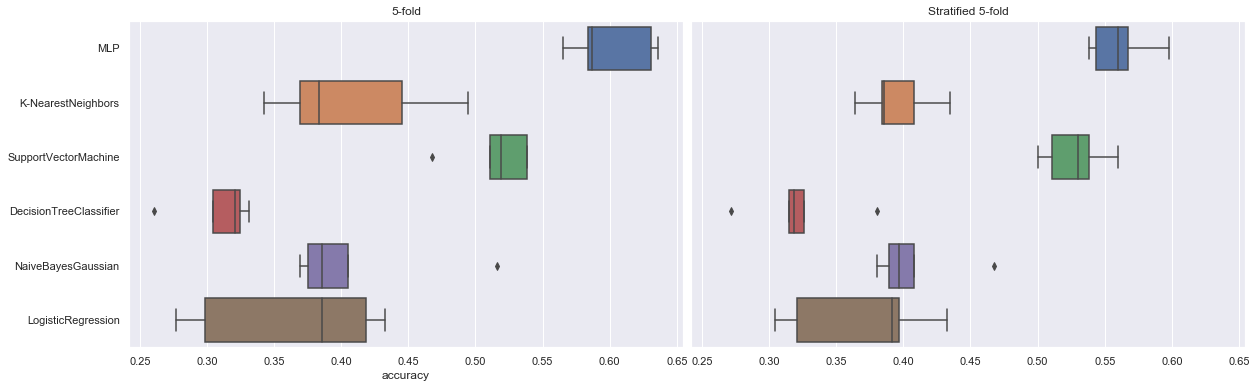

In [80]:
style.use('seaborn-whitegrid')
sns.set_palette("muted", 10)
sns.set()

fig = plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(20,6), sharey=True, sharex=True,
                        gridspec_kw={'wspace': 0.015, 'hspace': 0.15})

sns.boxplot(x='accuracy', y='clf_name', data=val_res['5-fold'], ax=axs[0])
axs[0].set_title('5-fold')
axs[0].yaxis.label.set_visible(False)

sns.boxplot(x='accuracy', y='clf_name', data=val_res['Stratified 5-fold'], ax=axs[1])
axs[1].set_title('Stratified 5-fold')
axs[1].yaxis.label.set_visible(False)
axs[1].xaxis.label.set_visible(False)
plt.show()

<Figure size 432x288 with 0 Axes>

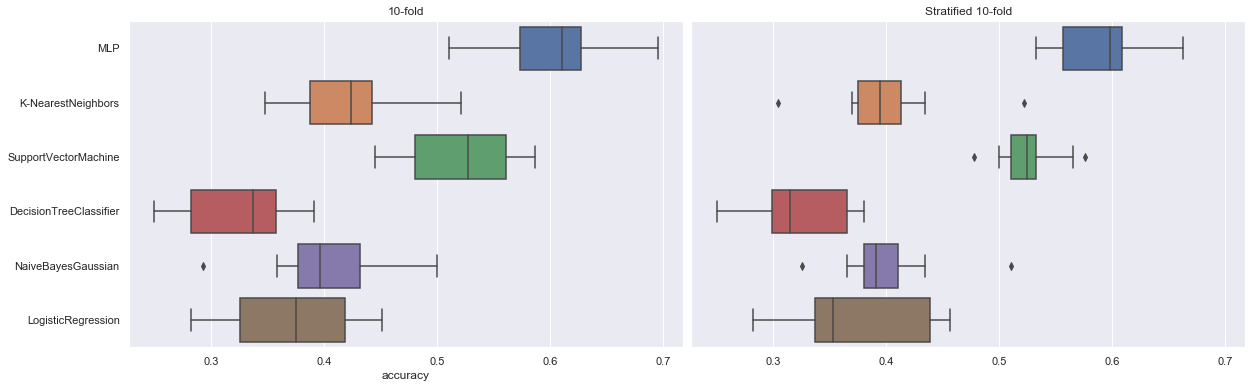

In [81]:
fig = plt.figure()
fig, axs = plt.subplots(1, 2, figsize=(20,6), sharey=True, sharex=True,
                        gridspec_kw={'wspace': 0.015, 'hspace': 0.15})

sns.boxplot(x='accuracy', y='clf_name', data=val_res['10-fold'], ax=axs[0])
axs[0].set_title('10-fold')
axs[0].yaxis.label.set_visible(False)
sns.boxplot(x='accuracy', y='clf_name', data=val_res['Stratified 10-fold'], ax=axs[1])
axs[1].set_title('Stratified 10-fold')
axs[1].yaxis.label.set_visible(False)
axs[1].xaxis.label.set_visible(False)
plt.show()

In [83]:
df5cv = val_res['5-fold'].groupby('clf_name').accuracy.describe()[['mean', 'std', 'min', 'max']]
dfS5cv = val_res['Stratified 5-fold'].groupby('clf_name').accuracy.describe()[['mean', 'std', 'min', 'max']]
df10cv = val_res['10-fold'].groupby('clf_name').accuracy.describe()[['mean', 'std', 'min', 'max']]
dfS10cv = val_res['Stratified 10-fold'].groupby('clf_name').accuracy.describe()[['mean', 'std', 'min', 'max']]
pickle.dump((df5cv, dfS5cv, df10cv, dfS10cv), open("norm-regsplit-cv-frames.pickle","wb"))

print("5-FOLD CV ====================================================")
print(df5cv)
print("\nSTRAT 5-FOLD CV ==============================================")
print(dfS5cv)
print("\n10-FOLD CV ===================================================")
print(df10cv)
print("\nSTRAT 10-FOLD CV =============================================")
print(dfS10cv)

5-FOLD CV ====================================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.308343  0.028345  0.260870  0.331522
K-NearestNeighbors      0.407192  0.061798  0.342391  0.494565
LogisticRegression      0.362573  0.070523  0.277174  0.432432
MLP                     0.600452  0.031044  0.565217  0.635870
NaiveBayesGaussian      0.410429  0.060752  0.369565  0.516304
SupportVectorMachine    0.514653  0.028985  0.467391  0.538043

STRAT 5-FOLD CV ==============================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.322479  0.038768  0.271739  0.380435
K-NearestNeighbors      0.395235  0.026942  0.364130  0.434783
LogisticRegression      0.369095  0.054332  0.304348  0.432432
MLP                     0.561340  0.023634  0.538043  

### NORMALIZED FEATURES Regular train-test split (8:2)

```
5-FOLD CV ====================================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.308343  0.028345  0.260870  0.331522
K-NearestNeighbors      0.407192  0.061798  0.342391  0.494565
LogisticRegression      0.362573  0.070523  0.277174  0.432432
MLP                     0.600452  0.031044  0.565217  0.635870
NaiveBayesGaussian      0.410429  0.060752  0.369565  0.516304
SupportVectorMachine    0.514653  0.028985  0.467391  0.538043

STRAT 5-FOLD CV ==============================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.322479  0.038768  0.271739  0.380435
K-NearestNeighbors      0.395235  0.026942  0.364130  0.434783
LogisticRegression      0.369095  0.054332  0.304348  0.432432
MLP                     0.561340  0.023634  0.538043  0.597826
NaiveBayesGaussian      0.408273  0.034524  0.380435  0.467391
SupportVectorMachine    0.527685  0.023404  0.500000  0.559783

10-FOLD CV ===================================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.326788  0.048739  0.250000  0.391304
K-NearestNeighbors      0.421295  0.049732  0.347826  0.521739
LogisticRegression      0.371248  0.059174  0.282609  0.451613
MLP                     0.603682  0.053376  0.510870  0.695652
NaiveBayesGaussian      0.403939  0.059907  0.293478  0.500000
SupportVectorMachine    0.520056  0.050435  0.445652  0.586957

STRAT 10-FOLD CV =============================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.326788  0.043320  0.250000  0.380435
K-NearestNeighbors      0.400655  0.055301  0.304348  0.521739
LogisticRegression      0.373422  0.064379  0.282609  0.456522
MLP                     0.590615  0.041458  0.532609  0.663043
NaiveBayesGaussian      0.399603  0.048579  0.326087  0.510870
SupportVectorMachine    0.525526  0.029223  0.478261  0.576087
```

### NORMALIZED FEATURES Stratified train-test split (8:2)

```
5-FOLD CV ====================================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.295311  0.044736  0.250000  0.364130
K-NearestNeighbors      0.409365  0.029355  0.375000  0.445652
LogisticRegression      0.347409  0.028854  0.315217  0.383784
MLP                     0.564659  0.051376  0.513514  0.625000
NaiveBayesGaussian      0.386522  0.014555  0.369565  0.402174
SupportVectorMachine    0.492914  0.037022  0.451087  0.532609

STRAT 5-FOLD CV ==============================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.299618  0.038813  0.260870  0.351351
K-NearestNeighbors      0.414777  0.013441  0.396739  0.429348
LogisticRegression      0.371322  0.022625  0.331522  0.385870
MLP                     0.567914  0.050862  0.518919  0.646739
NaiveBayesGaussian      0.395235  0.018086  0.369565  0.413043
SupportVectorMachine    0.510306  0.031237  0.456522  0.538043

10-FOLD CV ===================================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.300736  0.035631  0.206522  0.326087
K-NearestNeighbors      0.419074  0.058815  0.336957  0.543478
LogisticRegression      0.368093  0.031514  0.315217  0.413043
MLP                     0.566865  0.062418  0.483871  0.684783
NaiveBayesGaussian      0.395302  0.056899  0.315217  0.500000
SupportVectorMachine    0.511454  0.047914  0.462366  0.619565

STRAT 10-FOLD CV =============================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.342052  0.028563  0.311828  0.391304
K-NearestNeighbors      0.422288  0.049691  0.347826  0.510870
LogisticRegression      0.379991  0.048569  0.282609  0.456522
MLP                     0.567835  0.054133  0.500000  0.673913
NaiveBayesGaussian      0.394191  0.045710  0.344086  0.478261
SupportVectorMachine    0.508135  0.043569  0.434783  0.565217
```

### Stratified train-test split (8:2)

```
5-FOLD CV ====================================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.343137  0.038635  0.293478  0.385870
K-NearestNeighbors      0.301874  0.018787  0.275676  0.326087
LogisticRegression      0.521134  0.043347  0.456522  0.565217
MLP                     0.281175  0.052852  0.190217  0.318919
NaiveBayesGaussian      0.324636  0.044271  0.266304  0.375000
SupportVectorMachine    0.225852  0.040845  0.168478  0.282609

STRAT 5-FOLD CV ==============================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.346381  0.054125  0.298913  0.429348
K-NearestNeighbors      0.309459  0.014188  0.297297  0.331522
LogisticRegression      0.529812  0.036441  0.472826  0.572973
MLP                     0.350605  0.057126  0.298913  0.443243
NaiveBayesGaussian      0.345270  0.036892  0.309783  0.402174
SupportVectorMachine    0.263837  0.012304  0.244565  0.277174

10-FOLD CV ===================================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.351800  0.054563  0.282609  0.467391
K-NearestNeighbors      0.306183  0.045714  0.250000  0.402174
LogisticRegression      0.549392  0.051126  0.456522  0.608696
MLP                     0.296505  0.048783  0.215054  0.369565
NaiveBayesGaussian      0.347429  0.055027  0.260870  0.423913
SupportVectorMachine    0.216047  0.035120  0.163043  0.271739

STRAT 10-FOLD CV =============================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.353950  0.047998  0.293478  0.434783
K-NearestNeighbors      0.321388  0.030365  0.282609  0.369565
LogisticRegression      0.541784  0.050573  0.456522  0.597826
MLP                     0.307200  0.061186  0.195652  0.376344
NaiveBayesGaussian      0.357165  0.050320  0.293478  0.434783
SupportVectorMachine    0.286629  0.046047  0.217391  0.347826
```

### Regular train-test split (8:2)

```
5-FOLD CV ====================================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.370217  0.050859  0.293478  0.429348
K-NearestNeighbors      0.318102  0.018342  0.298913  0.345946
LogisticRegression      0.545041  0.012572  0.532609  0.562162
MLP                     0.296322  0.075146  0.184783  0.383784
NaiveBayesGaussian      0.314841  0.023681  0.288043  0.345946
SupportVectorMachine    0.234489  0.034499  0.184783  0.270270

STRAT 5-FOLD CV ==============================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.374536  0.045601  0.309783  0.427027
K-NearestNeighbors      0.321328  0.032008  0.304348  0.378378
LogisticRegression      0.551533  0.039074  0.500000  0.592391
MLP                     0.332239  0.068080  0.244565  0.429348
NaiveBayesGaussian      0.310482  0.029346  0.282609  0.356757
SupportVectorMachine    0.265981  0.029581  0.233696  0.297297

10-FOLD CV ===================================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.397312  0.053447  0.315217  0.473118
K-NearestNeighbors      0.343069  0.041936  0.282609  0.413043
LogisticRegression      0.533018  0.054727  0.456522  0.623656
MLP                     0.322370  0.085928  0.184783  0.434783
NaiveBayesGaussian      0.310531  0.043815  0.239130  0.380435
SupportVectorMachine    0.239902  0.033626  0.195652  0.293478

STRAT 10-FOLD CV =============================================
                            mean       std       min       max
clf_name                                                      
DecisionTreeClassifier  0.369133  0.035455  0.315217  0.423913
K-NearestNeighbors      0.352828  0.029671  0.304348  0.397849
LogisticRegression      0.542847  0.045204  0.423913  0.580645
MLP                     0.318093  0.080333  0.195652  0.423913
NaiveBayesGaussian      0.313756  0.047362  0.239130  0.402174
SupportVectorMachine    0.262763  0.025040  0.217391  0.304348
```

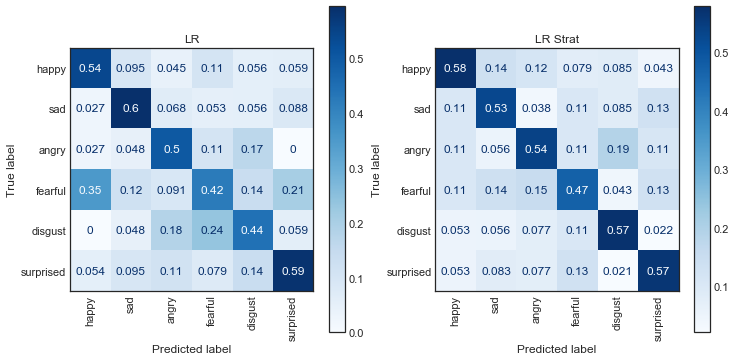

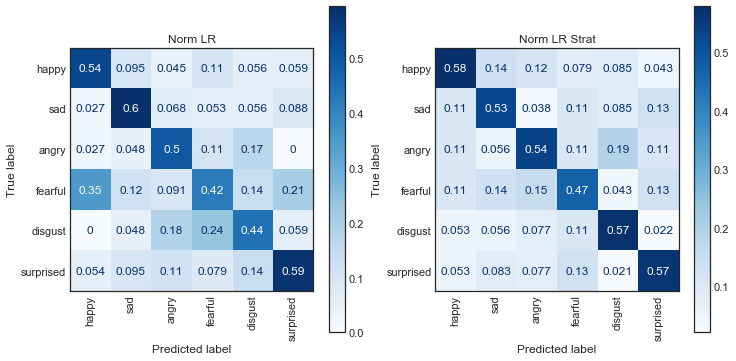

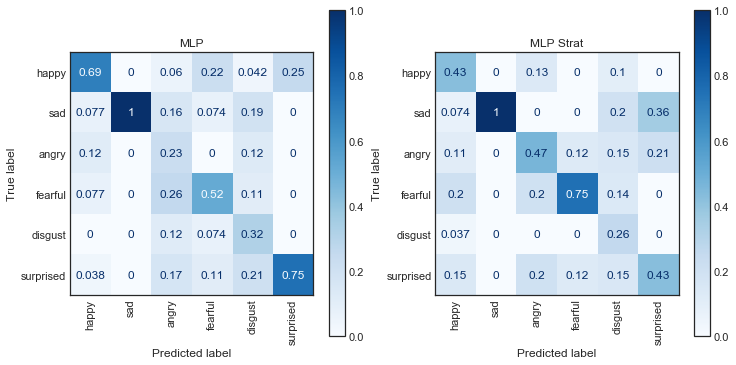

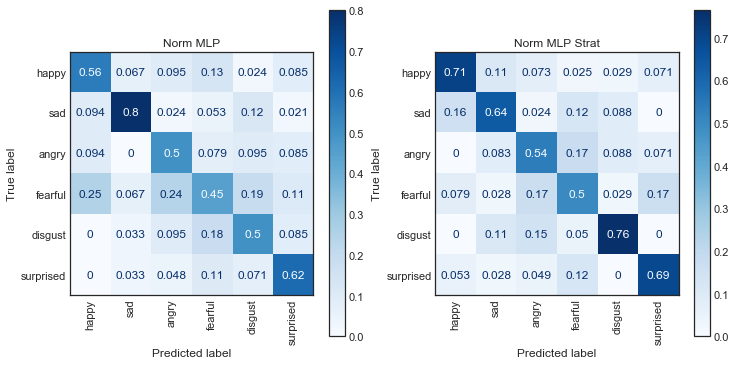

In [90]:
from sklearn.metrics import plot_confusion_matrix
style.use('seaborn-white')

def plot_model_cm(name, model, xtrain, ytrain, xtest, ytest, ax=None):
    random.seed(0)
    np.random.seed(0)
    model.fit(xtrain, ytrain)
    fig = plot_confusion_matrix(model, xtest, ytest,
                      display_labels=observed_emotions,
                      cmap=plt.cm.Blues, xticks_rotation='vertical', 
                      normalize='pred', values_format='.2f', ax=ax)
    fig.ax_.set_title(name)

fig, axs = plt.subplots(1,2, figsize=(12,6))
plot_model_cm("LR", lr, x_train, y_train, x_test, y_test, ax=axs[0])
plot_model_cm("LR Strat", lr, x_train_strat, y_train_strat, x_test_strat, y_test_strat, ax=axs[1])
plt.show()

fig, axs = plt.subplots(1,2, figsize=(12,6))
plot_model_cm("Norm LR", lr, x_train, y_train, x_test, y_test, ax=axs[0])
plot_model_cm("Norm LR Strat", lr, x_train_strat, y_train_strat, x_test_strat, y_test_strat, ax=axs[1])
plt.show()

fig, axs = plt.subplots(1,2, figsize=(12,6))
plot_model_cm("MLP", mlp, x_train, y_train, x_test, y_test, ax=axs[0])
plot_model_cm("MLP Strat", mlp, x_train_strat, y_train_strat, x_test_strat, y_test_strat, ax=axs[1])
plt.show()

fig, axs = plt.subplots(1,2, figsize=(12,6))
plot_model_cm("Norm MLP", mlp, xn_train, yn_train, xn_test, yn_test, ax=axs[0])
plot_model_cm("Norm MLP Strat", mlp, xn_train_strat, yn_train_strat, xn_test_strat, yn_test_strat, ax=axs[1])
plt.show()